In [18]:
from sandbox_assets import *
from grapher import Grapher
from qiskit.circuit.library import RealAmplitudes, TwoLocal, EfficientSU2

import numpy as np
import matplotlib.pyplot as plt

In [10]:
seed = 1

In [20]:
obs = QuantumCircuit(qubits)
obs.x(range(qubits))
#obs.draw()

In [5]:
qubits = 5
basis_gates =  ['id', 'rz', 'sx', 'x', 'cx']
nb_shots = None
err_range = np.linspace(-3,-1, 5)
depol = True
thermal = True
opt_level = 0

## GHZ initial state

#### Reaction to change in depth:

In [22]:
layers_range = [*range(5)]

In [64]:
colors = np.flip(plt.cm.viridis(np.linspace(0,1,5)), 0)

5it [00:13,  2.67s/it]
5it [00:19,  3.84s/it]
5it [00:25,  5.01s/it]
5it [00:30,  6.16s/it]
5it [00:37,  7.41s/it]


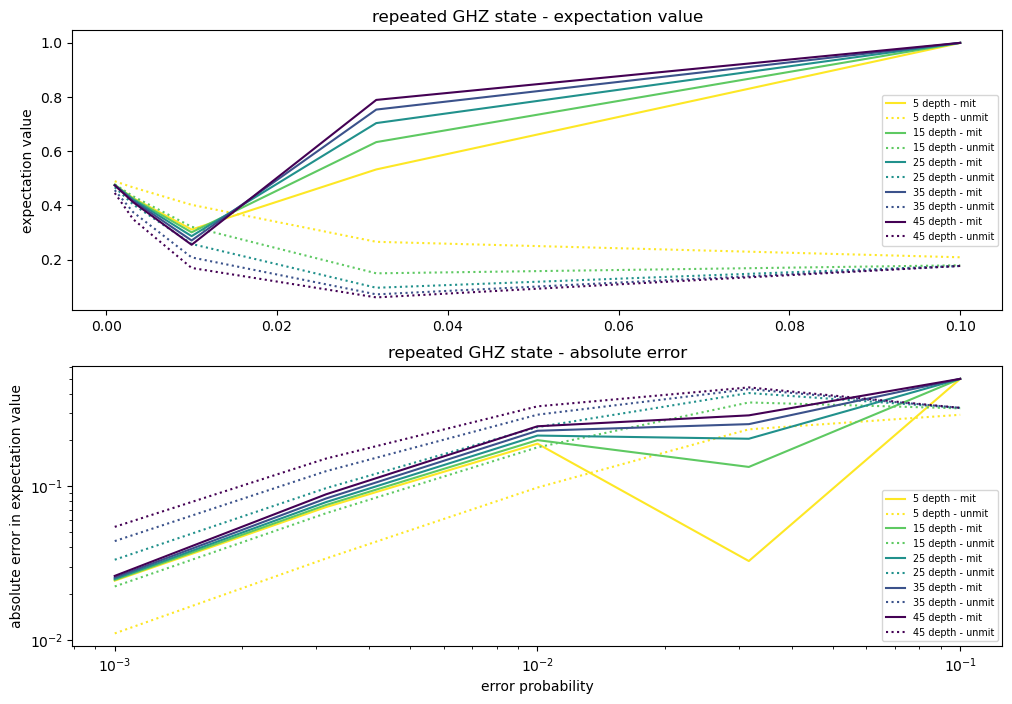

In [68]:
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize = (12, 8))

for layers in layers_range:

    initial_state = GHZreps(qubits = qubits, layers = layers)
    initial_state.rz(np.pi/3, 0)

    temp_GHZ = Grapher(copies=2, initial_state=initial_state, obs=obs, basis_gates=basis_gates,
                       nb_shots=nb_shots, error_range=err_range, depol=depol, thermal=thermal,
                       opt_level=opt_level, seed=seed)
    
    mit_unmit = temp_GHZ.expecsForGraph()
    temp_GHZ.exactExpectation()

    ax1.plot(10**err_range, mit_unmit[0][:], color = colors[layers], label = '{} depth - mit'.format(initial_state.depth()))
    ax1.plot(10**err_range, mit_unmit[1][:], color = colors[layers], linestyle = 'dotted', label = '{} depth - unmit'.format(initial_state.depth()))

    ax2.loglog(10**err_range, np.abs(mit_unmit[0][:] - temp_GHZ._exact_expectation), color = colors[layers], label = '{} depth - mit'.format(initial_state.depth()))
    ax2.loglog(10**err_range, np.abs(mit_unmit[1][:] - temp_GHZ._exact_expectation), color = colors[layers], linestyle = 'dotted', label = '{} depth - unmit'.format(initial_state.depth()))


ax1.legend(fontsize = 'x-small')
ax1.set(
    title = 'repeated GHZ state - expectation value',
    #xlabel = 'error probability',
    ylabel = 'expectation value'
)

ax2.legend(fontsize = 'x-small')
ax2.set(
    title = 'repeated GHZ state - absolute error',
    xlabel = 'error probability',
    ylabel = 'absolute error in expectation value'
)

plt.show()

#### Reaction to change in width:

In [6]:
qubits_range = [*range(3, 7, 1)]

In [7]:
colors = np.flip(plt.cm.viridis(np.linspace(0,1,5)), 0)

5it [00:00, 11.58it/s]
5it [00:01,  4.00it/s]
5it [00:13,  2.65s/it]
5it [03:36, 43.24s/it]


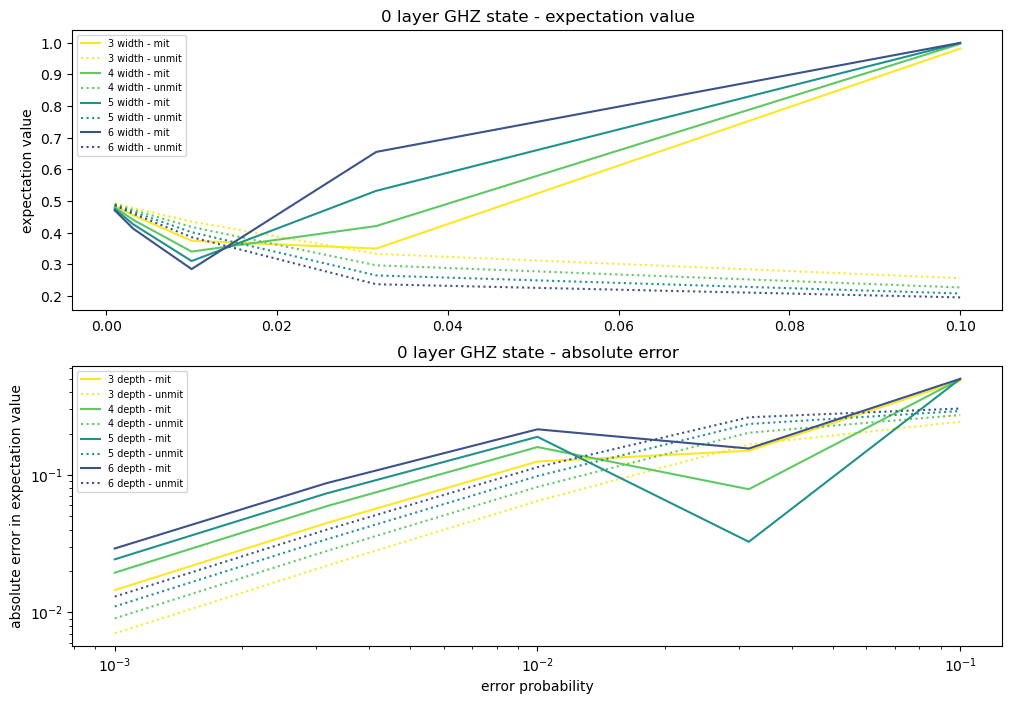

In [9]:
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize = (12, 8))

for qubits in qubits_range:

    initial_state = GHZreps(qubits = qubits, layers = 0)
    initial_state.rz(np.pi/3, 0)

    obs = QuantumCircuit(qubits)
    obs.x(range(qubits))

    temp_GHZ = Grapher(copies=2, initial_state=initial_state, obs=obs, basis_gates=basis_gates,
                       nb_shots=nb_shots, error_range=err_range, depol=depol, thermal=thermal,
                       opt_level=opt_level, seed=seed)
    
    mit_unmit = temp_GHZ.expecsForGraph()
    temp_GHZ.exactExpectation()

    ax1.plot(10**err_range, mit_unmit[0][:], color = colors[int(qubits-3)], label = '{} width - mit'.format(qubits))
    ax1.plot(10**err_range, mit_unmit[1][:], color = colors[int(qubits-3)], linestyle = 'dotted', label = '{} width - unmit'.format(qubits))

    ax2.loglog(10**err_range, np.abs(mit_unmit[0][:] - temp_GHZ._exact_expectation), color = colors[int(qubits-3)], label = '{} depth - mit'.format(initial_state.depth()))
    ax2.loglog(10**err_range, np.abs(mit_unmit[1][:] - temp_GHZ._exact_expectation), color = colors[int(qubits-3)], linestyle = 'dotted', label = '{} depth - unmit'.format(initial_state.depth()))


ax1.legend(fontsize = 'x-small')
ax1.set(
    title = '0 layer GHZ state - expectation value',
    #xlabel = 'error probability',
    ylabel = 'expectation value'
)

ax2.legend(fontsize = 'x-small')
ax2.set(
    title = '0 layer GHZ state - absolute error',
    xlabel = 'error probability',
    ylabel = 'absolute error in expectation value'
)

plt.show()

5it [00:00,  5.20it/s]
5it [00:02,  2.25it/s]
5it [00:31,  6.20s/it]
5it [09:06, 109.36s/it]


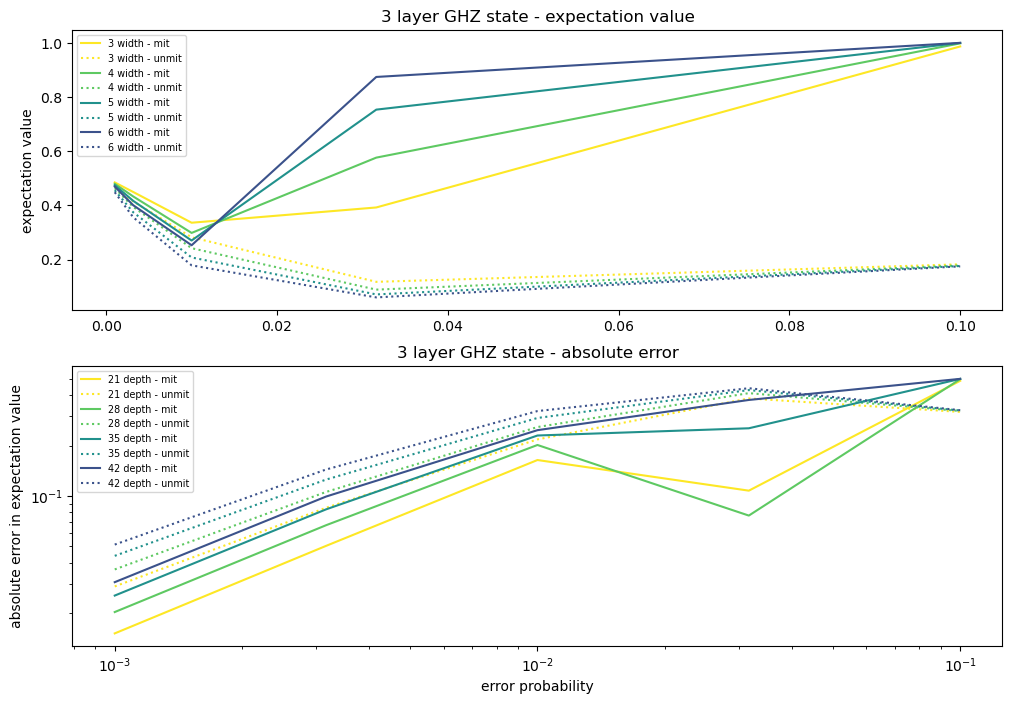

In [8]:
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize = (12, 8))

for qubits in qubits_range:

    initial_state = GHZreps(qubits = qubits, layers = 3)
    initial_state.rz(np.pi/3, 0)

    obs = QuantumCircuit(qubits)
    obs.x(range(qubits))

    temp_GHZ = Grapher(copies=2, initial_state=initial_state, obs=obs, basis_gates=basis_gates,
                       nb_shots=nb_shots, error_range=err_range, depol=depol, thermal=thermal,
                       opt_level=opt_level, seed=seed)
    
    mit_unmit = temp_GHZ.expecsForGraph()
    temp_GHZ.exactExpectation()

    ax1.plot(10**err_range, mit_unmit[0][:], color = colors[int(qubits-3)], label = '{} width - mit'.format(qubits))
    ax1.plot(10**err_range, mit_unmit[1][:], color = colors[int(qubits-3)], linestyle = 'dotted', label = '{} width - unmit'.format(qubits))

    ax2.loglog(10**err_range, np.abs(mit_unmit[0][:] - temp_GHZ._exact_expectation), color = colors[int(qubits-3)], label = '{} depth - mit'.format(initial_state.depth()))
    ax2.loglog(10**err_range, np.abs(mit_unmit[1][:] - temp_GHZ._exact_expectation), color = colors[int(qubits-3)], linestyle = 'dotted', label = '{} depth - unmit'.format(initial_state.depth()))


ax1.legend(fontsize = 'x-small')
ax1.set(
    title = '3 layer GHZ state - expectation value',
    #xlabel = 'error probability',
    ylabel = 'expectation value'
)

ax2.legend(fontsize = 'x-small')
ax2.set(
    title = '3 layer GHZ state - absolute error',
    xlabel = 'error probability',
    ylabel = 'absolute error in expectation value'
)

plt.show()

### Real amplitudes initial state

In [14]:
qubits = 5
basis_gates =  ['id', 'rz', 'sx', 'x', 'cx']
nb_shots = None
err_range = np.linspace(-3,-1, 5)
depol = True
thermal = True
opt_level = 0

obs = QuantumCircuit(qubits)
obs.x(range(qubits))

layers_range = [*range(5)]
colors = np.flip(plt.cm.viridis(np.linspace(0,1,5)), 0)

5it [00:10,  2.03s/it]
5it [00:13,  2.64s/it]
5it [00:17,  3.46s/it]
5it [00:21,  4.24s/it]
5it [00:26,  5.32s/it]


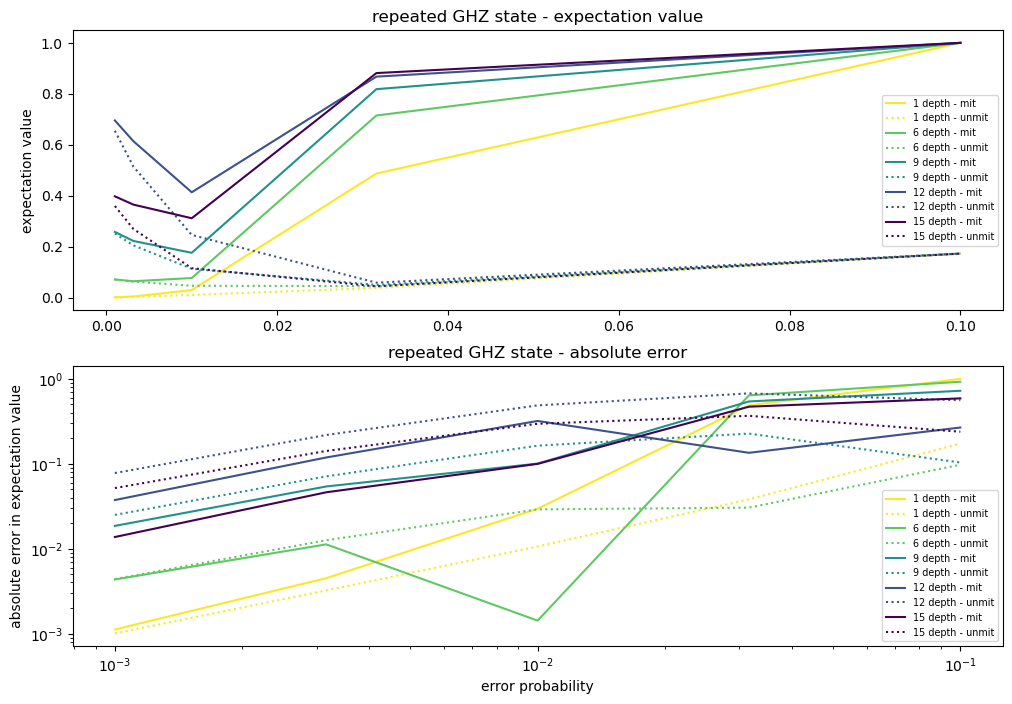

In [17]:
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize = (12, 8))

for layers in layers_range:

    initial_state = RealAmplitudes(num_qubits = qubits, reps=layers)
    np.random.seed(seed)
    initial_state = initial_state.assign_parameters(np.random.random(initial_state.num_parameters))

    initial_state = initial_state.decompose()

    temp_RealAmp = Grapher(copies=2, initial_state=initial_state, obs=obs, basis_gates=basis_gates,
                       nb_shots=nb_shots, error_range=err_range, depol=depol, thermal=thermal,
                       opt_level=opt_level, seed=seed)
    
    mit_unmit = temp_RealAmp.expecsForGraph()
    temp_RealAmp.exactExpectation()

    ax1.plot(10**err_range, mit_unmit[0][:], color = colors[layers], label = '{} depth - mit'.format(initial_state.depth()))
    ax1.plot(10**err_range, mit_unmit[1][:], color = colors[layers], linestyle = 'dotted', label = '{} depth - unmit'.format(initial_state.depth()))

    ax2.loglog(10**err_range, np.abs(mit_unmit[0][:] - temp_RealAmp._exact_expectation), color = colors[layers], label = '{} depth - mit'.format(initial_state.depth()))
    ax2.loglog(10**err_range, np.abs(mit_unmit[1][:] - temp_RealAmp._exact_expectation), color = colors[layers], linestyle = 'dotted', label = '{} depth - unmit'.format(initial_state.depth()))


ax1.legend(fontsize = 'x-small')
ax1.set(
    title = 'RealAmplitudes state - expectation value',
    #xlabel = 'error probability',
    ylabel = 'expectation value'
)

ax2.legend(fontsize = 'x-small')
ax2.set(
    title = 'RealAmplitudes state - absolute error',
    xlabel = 'error probability',
    ylabel = 'absolute error in expectation value'
)

plt.show()

### TwoLocal

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize = (12, 8))

for layers in layers_range:

    initial_state = TwoLocal(num_qubits = qubits, rotation_blocks= 'ry', entanglement_blocks= 'cx', reps=layers)
    np.random.seed(seed)
    initial_state = initial_state.assign_parameters(np.random.random(initial_state.num_parameters))

    initial_state = initial_state.decompose()

    temp_RealAmp = Grapher(copies=2, initial_state=initial_state, obs=obs, basis_gates=basis_gates,
                       nb_shots=nb_shots, error_range=err_range, depol=depol, thermal=thermal,
                       opt_level=opt_level, seed=seed)
    
    mit_unmit = temp_RealAmp.expecsForGraph()
    temp_RealAmp.exactExpectation()

    ax1.plot(10**err_range, mit_unmit[0][:], color = colors[layers], label = '{} depth - mit'.format(initial_state.depth()))
    ax1.plot(10**err_range, mit_unmit[1][:], color = colors[layers], linestyle = 'dotted', label = '{} depth - unmit'.format(initial_state.depth()))

    ax2.loglog(10**err_range, np.abs(mit_unmit[0][:] - temp_RealAmp._exact_expectation), color = colors[layers], label = '{} depth - mit'.format(initial_state.depth()))
    ax2.loglog(10**err_range, np.abs(mit_unmit[1][:] - temp_RealAmp._exact_expectation), color = colors[layers], linestyle = 'dotted', label = '{} depth - unmit'.format(initial_state.depth()))


ax1.legend(fontsize = 'x-small')
ax1.set(
    title = 'TwoLocal state - expectation value',
    #xlabel = 'error probability',
    ylabel = 'expectation value'
)

ax2.legend(fontsize = 'x-small')
ax2.set(
    title = 'TwoLocal state - absolute error',
    xlabel = 'error probability',
    ylabel = 'absolute error in expectation value'
)

plt.show()

### Efficient SU2:

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize = (12, 8))

for layers in layers_range:

    initial_state = EfficientSU2(num_qubits = qubits, su2_gates= ['rz', 'x'], entanglement= 'full', reps=layers)
    np.random.seed(seed)
    initial_state = initial_state.assign_parameters(np.random.random(initial_state.num_parameters))

    initial_state = initial_state.decompose()

    temp_RealAmp = Grapher(copies=2, initial_state=initial_state, obs=obs, basis_gates=basis_gates,
                       nb_shots=nb_shots, error_range=err_range, depol=depol, thermal=thermal,
                       opt_level=opt_level, seed=seed)
    
    mit_unmit = temp_RealAmp.expecsForGraph()
    temp_RealAmp.exactExpectation()

    ax1.plot(10**err_range, mit_unmit[0][:], color = colors[layers], label = '{} depth - mit'.format(initial_state.depth()))
    ax1.plot(10**err_range, mit_unmit[1][:], color = colors[layers], linestyle = 'dotted', label = '{} depth - unmit'.format(initial_state.depth()))

    ax2.loglog(10**err_range, np.abs(mit_unmit[0][:] - temp_RealAmp._exact_expectation), color = colors[layers], label = '{} depth - mit'.format(initial_state.depth()))
    ax2.loglog(10**err_range, np.abs(mit_unmit[1][:] - temp_RealAmp._exact_expectation), color = colors[layers], linestyle = 'dotted', label = '{} depth - unmit'.format(initial_state.depth()))


ax1.legend(fontsize = 'x-small')
ax1.set(
    title = 'EfficientSU2 state - expectation value',
    #xlabel = 'error probability',
    ylabel = 'expectation value'
)

ax2.legend(fontsize = 'x-small')
ax2.set(
    title = 'EfficientSU2 state - absolute error',
    xlabel = 'error probability',
    ylabel = 'absolute error in expectation value'
)

plt.show()